# Improving Linear Regression with Neural Networks (Logistic Regression)

This function shows how to use TensorFlow to solve logistic regression with a multiple layer neural network

$$
\textbf{y} = sigmoid(\textbf{A}_{3} \times sigmoid(\textbf{A}_{2} \times sigmoid(\textbf{A}_{1} \times \textbf{x} + \textbf{b}_{1}) + \textbf{b}_{2}) + \textbf{b}_{3})
$$

We will use the low birth weight data, specifically:
```
  y = 0 or 1 = low birth weight
  x = demographic and medical history data
```

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import requests
import os.path
import csv

## Obtain and prepare data for modeling

In [ ]:
# name of data file
birth_weight_file = 'birth_weight.csv'

# download data and create data file if file does not exist in current directory
if not os.path.exists(birth_weight_file):
    birthdata_url = 'https://github.com/nfmcclure/tensorflow_cookbook/raw/master/01_Introduction/07_Working_with_Data_Sources/birthweight_data/birthweight.dat'
    birth_file = requests.get(birthdata_url)
    birth_data = birth_file.text.split('\r\n')
    birth_header = birth_data[0].split('\t')
    birth_data = [[float(x) for x in y.split('\t') if len(x)>=1] for y in birth_data[1:] if len(y)>=1]
    with open(birth_weight_file, "w") as f:
        writer = csv.writer(f)
        writer.writerows(birth_data)
        f.close()

# read birth weight data into memory
birth_data = []
with open(birth_weight_file, newline='') as csvfile:
     csv_reader = csv.reader(csvfile)
     birth_header = next(csv_reader)
     for row in csv_reader:
         birth_data.append(row)

birth_data = [[float(x) for x in row] for row in birth_data]

# Pull out target variable
y_vals = np.array([x[0] for x in birth_data])
# Pull out predictor variables (not id, not target, and not birthweight)
x_vals = np.array([x[1:8] for x in birth_data])

# set for reproducible results
seed = 98
np.random.seed(seed)
tf.random.set_seed(seed)

# Declare batch size
batch_size = 90

# Split data into train/test = 80%/20%
train_indices = np.random.choice(len(x_vals), round(len(x_vals)*0.8), replace=False)
test_indices = np.array(list(set(range(len(x_vals))) - set(train_indices)))
x_vals_train = x_vals[train_indices]
x_vals_test = x_vals[test_indices]
y_vals_train = y_vals[train_indices]
y_vals_test = y_vals[test_indices]

# Normalize by column (min-max norm)
def normalize_cols(m):
    col_max = m.max(axis=0)
    col_min = m.min(axis=0)
    return (m-col_min) / (col_max - col_min)
    
x_vals_train = np.nan_to_num(normalize_cols(x_vals_train))
x_vals_test = np.nan_to_num(normalize_cols(x_vals_test))

## Define Tensorflow computational graph

In [ ]:
tf.keras.backend.set_floatx("float64")

# Initialize input data
x_data = tf.keras.Input(dtype=tf.float64, shape=(7,))

# Create variable definition
def init_variable(shape):
    return(tf.Variable(tf.random.normal(shape=shape, dtype="float64", seed=seed)))


# Create a logistic layer definition
def logistic(input_layer, multiplication_weight, bias_weight, activation = True):
    
    # We separate the activation at the end because the loss function will
    # implement the last sigmoid necessary
    if activation:
        return tf.keras.layers.Lambda(lambda x: tf.nn.sigmoid(tf.add(tf.matmul(x, multiplication_weight), bias_weight)))(input_layer)
    else:
        return tf.keras.layers.Lambda(lambda x: tf.add(tf.matmul(x, multiplication_weight), bias_weight))(input_layer)


# First logistic layer (7 inputs to 14 hidden nodes)
A1 = init_variable(shape=[7,14])
b1 = init_variable(shape=[14])
logistic_layer1 = logistic(x_data, A1, b1)

# Second logistic layer (14 hidden inputs to 5 hidden nodes)
A2 = init_variable(shape=[14,5])
b2 = init_variable(shape=[5])
logistic_layer2 = logistic(logistic_layer1, A2, b2)

# Final output layer (5 hidden nodes to 1 output)
A3 = init_variable(shape=[5,1])
b3 = init_variable(shape=[1])
final_output = logistic(logistic_layer2, A3, b3, activation=False)

# Build the model
model = tf.keras.Model(inputs=x_data, outputs=final_output, name="improving_linear_reg_neural_network")

The following Variables were used a Lambda layer's call (lambda), but
are not present in its tracked objects:
  <tf.Variable 'Variable:0' shape=(7, 14) dtype=float64>
  <tf.Variable 'Variable:0' shape=(14,) dtype=float64>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (lambda_1), but
are not present in its tracked objects:
  <tf.Variable 'Variable:0' shape=(14, 5) dtype=float64>
  <tf.Variable 'Variable:0' shape=(5,) dtype=float64>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (lambda_2), but
are not present in its tracked objects:
  <tf.Variable 'Variable:0' shape=(5, 1) dtype=fl

## Train model

In [ ]:
# Declare optimizer
optimizer = tf.keras.optimizers.Adam(0.002)

# Accuracy
def compute_accuracy(final_output, y_target):
    prediction = tf.round(tf.nn.sigmoid(final_output))
    predictions_correct = tf.cast(tf.equal(prediction, y_target), tf.float32)
    return tf.reduce_mean(predictions_correct)


# Loss function (Cross Entropy loss)
def cross_entropy(final_output, y_target):
    return tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=final_output, labels=y_target))

# Training loop
loss_vec = []
train_acc = []
test_acc = []
for i in range(1500):
    rand_index = np.random.choice(len(x_vals_train), size=batch_size)
    rand_x = x_vals_train[rand_index]
    rand_y = np.transpose([y_vals_train[rand_index]])
    
     # Open a GradientTape.
    with tf.GradientTape(persistent=True) as tape:
   
        # Forward pass.
        output = model(rand_x)
        
        # Apply loss function (Cross Entropy loss)
        loss = cross_entropy(output, rand_y)
        loss_vec.append(loss)

    # Get gradients of loss with reference to the weights and bias variables to adjust.
    gradients_A1 = tape.gradient(loss, A1)
    gradients_b1 = tape.gradient(loss, b1)
    gradients_A2 = tape.gradient(loss, A2)
    gradients_b2 = tape.gradient(loss, b2)
    gradients_A3 = tape.gradient(loss, A3)
    gradients_b3 = tape.gradient(loss, b3)
    
    # Update the weights and bias variables of the model.
    optimizer.apply_gradients(zip([gradients_A1, gradients_b1,gradients_A2, gradients_b2, gradients_A3, gradients_b3], 
                                  [A1, b1, A2, b2, A3, b3]))
    
    temp_acc_train = compute_accuracy(model(x_vals_train), np.transpose([y_vals_train]))
    train_acc.append(temp_acc_train)
    
    temp_acc_test = compute_accuracy(model(x_vals_test), np.transpose([y_vals_test]))
    test_acc.append(temp_acc_test)
    
    if (i+1)%150==0:
        print('Loss = ' + str(loss.numpy()))
        

Loss = 0.5885411040188063
Loss = 0.581099555117532
Loss = 0.6071769535895101
Loss = 0.5043174136225906
Loss = 0.5023625777095964
Loss = 0.485112570717733
Loss = 0.5906992621835641
Loss = 0.4280814147901789
Loss = 0.5425164697605331
Loss = 0.35608561907724867


## Display model performance

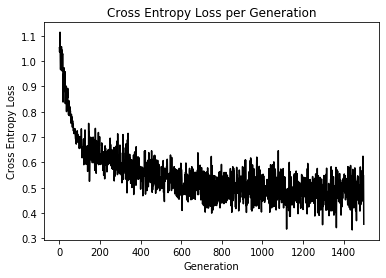

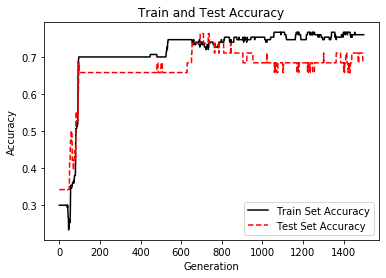

In [ ]:
%matplotlib inline
# Plot loss over time
plt.plot(loss_vec, 'k-')
plt.title('Cross Entropy Loss per Generation')
plt.xlabel('Generation')
plt.ylabel('Cross Entropy Loss')
plt.show()

# Plot train and test accuracy
plt.plot(train_acc, 'k-', label='Train Set Accuracy')
plt.plot(test_acc, 'r--', label='Test Set Accuracy')
plt.title('Train and Test Accuracy')
plt.xlabel('Generation')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()